# Pairs Trading on MSFT And ADBE using Kalman Filter Regression
*Author: Tejas Narendra Chaudhari*

In [2]:
%matplotlib inline

Imports

In [3]:
import numpy as np
import pandas as pd
import yfinance as yf 
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

Fetching data using Yahoo Finance API. 

In [4]:
stock2 = pd.DataFrame(yf.download('MSFT',start='2018-01-01',end='2019-12-31'))
stock1 = pd.DataFrame(yf.download('ADBE',start='2018-01-01',end='2019-12-31'))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Visualizing the Data

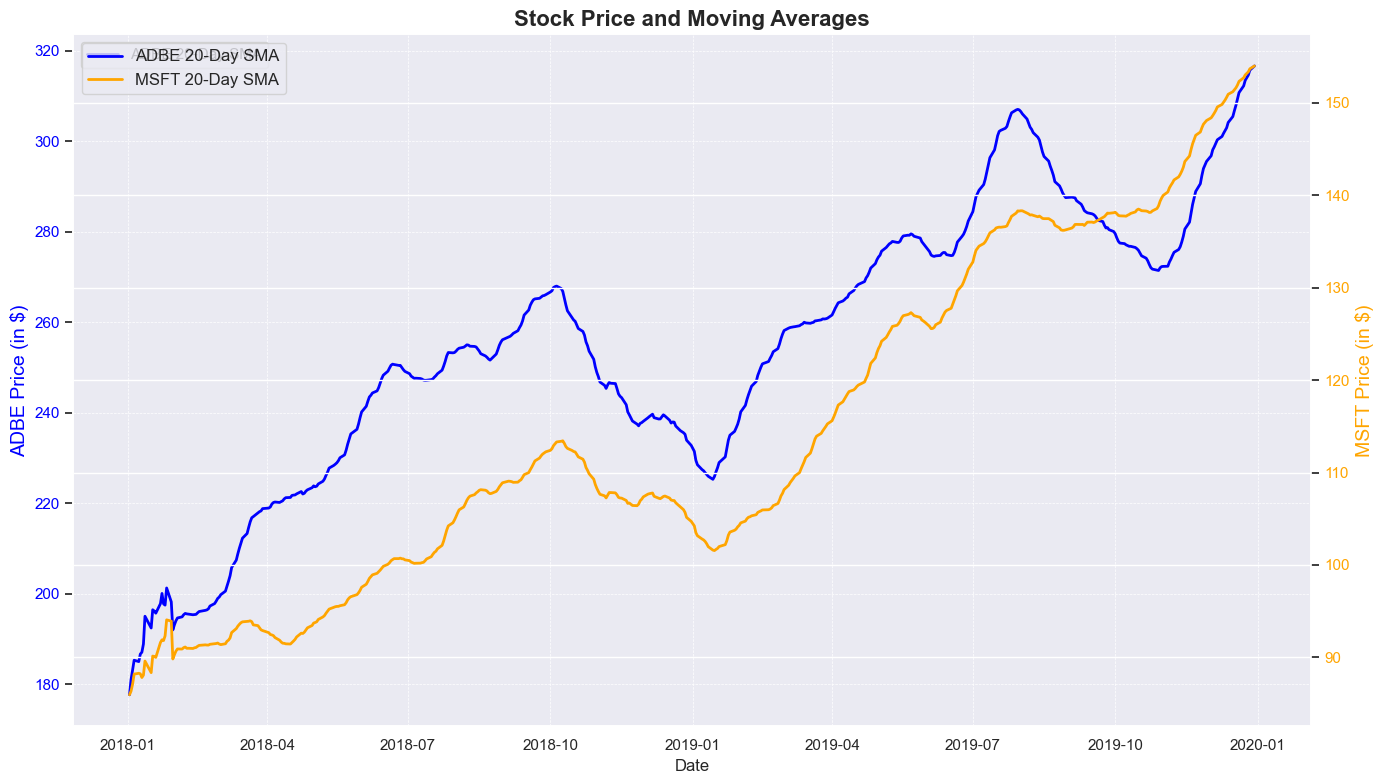

In [5]:
import warnings
warnings.filterwarnings('ignore')

# Add moving averages for better visualization
stock1['SMA_20'] = stock1['Close'].rolling(window=20).mean()
stock2['SMA_20'] = stock2['Close'].rolling(window=20).mean()
stock1['SMA_20'].fillna(stock1['Close'], inplace=True)
stock2['SMA_20'].fillna(stock2['Close'], inplace=True)

# Set theme
sns.set_theme(style='darkgrid')

# Plot
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot ADBE
sns.lineplot(data=stock1, x=stock1.index, y='SMA_20', ax=ax1, label='ADBE 20-Day SMA', color='blue', linewidth=2)
ax1.set_ylabel("ADBE Price (in $)", fontsize=14, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot MSFT on the same plot with a secondary y-axis
ax2 = ax1.twinx()
sns.lineplot(data=stock2, x=stock2.index, y='SMA_20', ax=ax2, label='MSFT 20-Day SMA', color='orange', linewidth=2)
ax2.set_ylabel("MSFT Price (in $)", fontsize=14, color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add title and labels
plt.title("Stock Price and Moving Averages", fontsize=16, fontweight='bold')
plt.xlabel("Year", fontsize=14)

# Add legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left', fontsize=12)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

## Testing Whether The Data Is Suitable For Pairs Trading

### Co-Integration Test

In [6]:
from statsmodels.tsa.stattools import coint # Augmented Engle Granger Test
import statsmodels.api as sm

In [7]:
(_,p_value,__) = coint(stock1['Close'], stock2['Close'], trend='c', method='aeg') # Note: only one method is available for testing CoIntegration in statsmodels
p_value

0.03515727313607433

## Testing The Strategy

In [8]:
from pykalman import KalmanFilter

In [9]:
class Backtest():
    """  
    Backtest the trading strategy on the given price series.
    
    Model: 
    y_t = alpha_t + beta_t * x_t + epsilon_t
    x_t corresponds to the price of the first stock at time t.
    y_t corresponds to the price of the second stock at time t.

    Parameters:
    s1 (pd.Series): The price series of the first stock.
    s2 (pd.Series): The price series of the second stock.

    Attributes:
    """

    def __init__(self, s1, s2, entryZscore=2, exitZscore=1, transaction_cost=0.1):
        self.s1 = s1
        self.s2 = s2
        state_means = self.KalmanFilterRegression(self.KalmanFilterAverage(s1), self.KalmanFilterAverage(s2))
        self.hedge_ratio = state_means[:,0]
        self.alpha = state_means[:,1]
        self.spread = s2 - self.hedge_ratio * s1 - self.alpha 
        self.entryZscore = entryZscore
        self.exitZscore = exitZscore
        self.transaction_cost = transaction_cost
                
    def KalmanFilterAverage(self, x):
        """
        Apply a Kalman filter to a series of observations to estimate the rolling mean.
        Parameters:
        x (pd.Series): A pandas Series containing the observed values of the price.
        Returns:
        pd.Series: A pandas Series containing the estimated rolling mean of the observed values.
        """
        # Construct a Kalman filter
        kf = KalmanFilter(transition_matrices = [1],  # State is constant
                          observation_matrices = [1], # Observation is our measurement
                          initial_state_mean = x[0], # First value is the initial state
                          initial_state_covariance = 1, # Some uncertainty
                          observation_covariance=1, # Noisy measurements
                          transition_covariance=.01 # Some uncertainty
                          )

        # Use the observed values of the price to get a rolling mean
        state_means, state_covs = kf.filter(x.values)
        state_means = pd.Series(state_means.flatten(), index=x.index)
        return state_means

    def KalmanFilterRegression(self, x, y):
        """
        Applies Kalman Filter Regression to the given input data.

        Parameters:
        x (array-like): The independent variable data.
        y (array-like): The dependent variable data.

        Returns:
        numpy.ndarray: The estimated state means for the regression parameters (alpha, beta) over time.
        
        Description:
        This function uses the Kalman Filter to estimate the time-varying regression parameters (alpha, beta) for the relationship between the input variables x and y. The Kalman Filter is initialized with a random walk model for the state transition and a simple observation model. The function returns the running estimates of the state parameters (alpha, beta) based on the observations y.
        """
        delta = 1e-3
        trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
        obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)
        kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
                      initial_state_mean=[0,0],
                      initial_state_covariance=np.ones((2, 2)),
                      transition_matrices=np.eye(2),
                      observation_matrices=obs_mat,
                      observation_covariance=2,
                      transition_covariance=trans_cov)
        # Use the observations y to get running estimates and errors for the state parameters
        state_means, state_covs = kf.filter(y.values)
        return state_means

    def half_life(self):
        """
        Calculate the half-life of the mean-reverting series using the AR(1) Model
        Returns:
        float: The half-life of the mean-reverting series.
        """
        # Check for stationarity
        spread = self.spread
        adf_result = adfuller(spread, autolag='AIC')
        if adf_result[1] >= 0.05:
            print(adf_result[1])
            raise ValueError("Input spread must be stationary to calculate half-life.")

        spread_lag = spread.shift(1)
        spread_lag.iloc[0] = spread_lag.iloc[1]
        
        spread_ret = spread - spread_lag
        spread_ret.iloc[0] = spread_ret.iloc[1]

        spread_lag2 = sm.add_constant(spread_lag)

        model = sm.OLS(spread_ret, spread_lag2)
        res = model.fit()
        halflife = int(round(-np.log(2) / res.params[1],0))

        if halflife <= 0: # This might happen due to short term irregularities
            halflife = 1
        
        return halflife
        
    def simulate_trading(self):
        
        halflife = self.half_life()
        self.halflife = halflife
        
        meanSpread = self.spread.rolling(window=halflife).mean()
        stdSpread = self.spread.rolling(window=halflife).std()

        zscore = (self.spread - meanSpread) / stdSpread

        # Simulate trading

        # Set entry threshold
        entryZscore = self.entryZscore
        # Set exit threshold
        exitZscore = self.exitZscore
        
        # Initialize positions
        long_position = False 
        short_position = False
        trades = []

        # Long Position: When zscore <= -entryZscore
        # Short Position: When zscore >= entryZscore
        # Exit Position: When zscore >= -exitZscore and zscore <= exitZscore

        for i in range(halflife, len(self.s1)):
            if zscore[i] >= entryZscore :
                short_position = True
                trades.append(-1)
            elif zscore[i] <= -entryZscore :
                long_position = True
                trades.append(1)
            elif abs(zscore[i]) < exitZscore and (long_position or short_position):
                long_position = False
                short_position = False
                trades.append(3) # Exit all positionons
            else:
                trades.append(0) # No position
        
        money = 0	
        pnl = []
        countS1 = 0
        countS2 = 0
        position_value = 0 # 0: No position, 1: Long position, -1: Short position
        exposure = []
        square_off_pnls = []

        countsS1 = []
        countsS2 = []

        for i in range(halflife, len(self.s1)):
            
            if trades[i-halflife]==1: # long position on the spread => short s1, long s2		
                # Close any existing short position on the spread
                if position_value < 0:
                    money += countS2 * self.s2[i] + countS1 * self.s1[i] - self.transaction_cost
                    countS1 = 0
                    countS2 = 0
                # Open long position
                money += self.hedge_ratio[i] * self.s1[i] - self.s2[i] - self.transaction_cost
                countS1 -= self.hedge_ratio[i]
                countS2 += 1
                position_value = 1

            elif trades[i-halflife]==-1: # short position on the spread => long s1, short s2
                # Close any existing long position on the spread
                if position_value == 1 :
                    money += countS2 * self.s2[i] + countS1 * self.s1[i] - self.transaction_cost
                    countS1 = 0	
                    countS2 = 0
                # Open short position
                money -= self.hedge_ratio[i] * self.s1[i] - self.s2[i] - self.transaction_cost
                countS1 += self.hedge_ratio[i]
                countS2 -= 1
                position_value = -1

            elif trades[i-halflife]==3: # exit all positions
                money += countS2 * self.s2[i] + countS1 * self.s1[i] - self.transaction_cost
                countS1 = 0
                countS2 = 0
                position_value = 0
                square_off_pnls.append(money)

            countsS1.append(countS1)
            countsS2.append(countS2)
            exposure.append(countS2 * self.s2[i] + countS1 * self.s1[i])
            pnl.append(money + countS2 * self.s2[i] + countS1 * self.s1[i]) 

        if (countS1!=0) or (countS2!=0): # This is for calculating the hit rate (ignore otherwise)
            square_off_pnls.append(money + countS2 * self.s2[i] + countS1 * self.s1[i] - self.transaction_cost)
        
        # Find hit rate
        succesful_trades = 0
        total_trades = 0
        for idx in range(1,len(square_off_pnls)):
            if square_off_pnls[idx] > square_off_pnls[idx-1]:
                succesful_trades += 1
            total_trades += 1
        try:
            hit_rate = succesful_trades / total_trades * 100
        except ZeroDivisionError:
            hit_rate = 0
        
        pnl = pd.Series(pnl, index=self.s1.index[halflife:])
        exposure = pd.Series(exposure, index=self.s1.index[halflife:])
        trades = pd.Series(trades, index=self.s1.index[halflife:])    
        countsS1 = pd.Series(countsS1, index=self.s1.index[halflife:])
        countsS2 = pd.Series(countsS2, index=self.s1.index[halflife:])

        trade_log = pd.DataFrame({
                'Trade': trades, 
                'CountS1': countsS1, 
                'CountS2': countsS2, 
                'Stock1_Price': self.s1[halflife:],
                'Stock2_Price': self.s2[halflife:],
                'PnL': pnl
                }, index=self.s1.index[halflife:])

        self.trade_log = trade_log

        return pnl,trades,exposure,[hit_rate,succesful_trades,total_trades]

	

In [10]:
b = Backtest(stock1['Close'], stock2['Close'], entryZscore=1.0, exitZscore=0.75)
res = b.simulate_trading()
pnl = res[0]
trades = res[1]
exposure = res[2]
hit_rate = res[3][0]

In [19]:
# FInd sharpe ratio
p

Date
2018-01-09         NaN
2018-01-10   -1.100000
2018-01-11    6.976264
2018-01-12    3.586471
2018-01-16    0.022077
                ...   
2019-12-23    0.008683
2019-12-24    0.003510
2019-12-26    0.000000
2019-12-27    0.001313
2019-12-30    0.002411
Length: 497, dtype: float64

In [12]:
hit_rate, res[3][1], res[3][2]

(68.86792452830188, 73, 106)

In [13]:
exposure.max(), exposure.min()

(6.101165639257772, -17.132547383160954)

Checking the PnL status and Exposure over the testing period.

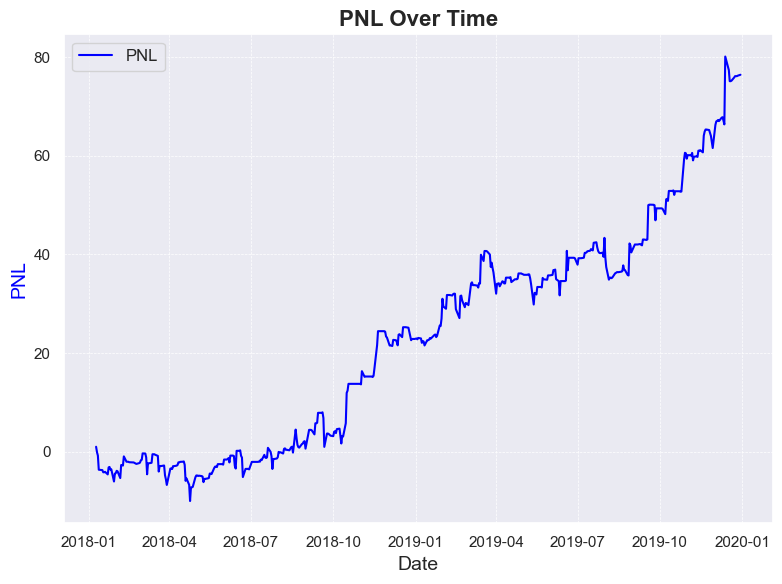

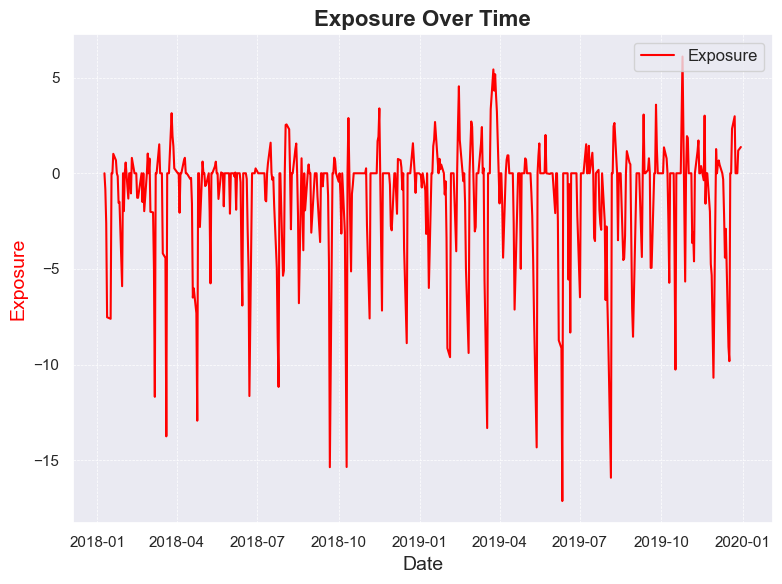

In [14]:
# Plot PNL
plt.figure(figsize=(8, 6))
plt.plot(pnl.index, pnl, label='PNL', color='blue')
plt.ylabel("PNL", fontsize=14, color='blue')
plt.xlabel("Date", fontsize=14)
plt.title("PNL Over Time", fontsize=16, fontweight='bold')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()

# Plot Exposure
plt.figure(figsize=(8, 6))
plt.plot(exposure.index, exposure, label='Exposure', color='red')
plt.ylabel("Exposure", fontsize=14, color='red')
plt.xlabel("Date", fontsize=14)
plt.title("Exposure Over Time", fontsize=16, fontweight='bold')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='upper right', fontsize=12)
plt.tight_layout()
plt.show()


The strategy seems quite market neutral overall, which means that the Kalman Filter is doing quite good job of estimating the Hedge Ratio.

In [15]:
import plotly.graph_objects as go

# Set theme
sns.set_theme(style='darkgrid')

# Simulate trading and get trades and spread
spread = b.spread[trades.index]
zscore = (spread - spread.rolling(window=b.half_life()).mean()) / spread.rolling(window=b.half_life()).std()

# Initialize a Plotly figure
fig = go.Figure()

# Add scatter plot for long positions
fig.add_trace(go.Scatter(
    x=trades[trades == 1].index,
    y=zscore[trades == 1],
    mode='markers',
    marker=dict(color='green', symbol='triangle-up', size=10),
    name='Long Spread Position'
))

# Add scatter plot for short positions
fig.add_trace(go.Scatter(
    x=trades[trades == -1].index,
    y=zscore[trades == -1],
    mode='markers',
    marker=dict(color='red', symbol='triangle-down', size=10),
    name='Short Spread Position'
))

# Add scatter plot for exit positions
fig.add_trace(go.Scatter(
    x=trades[trades == 3].index,
    y=zscore[trades == 3],
    mode='markers',
    marker=dict(color='gray', symbol='circle', size=10),
    name='Exit Spread Position'
))

# Add line plot for Z-Score
fig.add_trace(go.Scatter(
    x=spread.index,
    y=zscore,
    mode='lines',
    line=dict(color='blue', width=2),
    name='Z-Score'
))

# Update layout to enable horizontal scrolling
fig.update_layout(
    title='Plot of Spread Z-Score and Trading Positions',
    xaxis=dict(
        title='Year',
        rangeslider=dict(visible=True),  # Enables horizontal scrolling
    ),
    yaxis=dict(title='Spread'),
    legend=dict(title='Positions', x=1, y=1),
    template='plotly_dark',
    height=900,
    width=1500,
)

# Show the Plotly figure
fig.show()

In [16]:
import plotly.graph_objects as go

# Simulate trading and get trades and spread
spread = b.spread[trades.index]
zscore = (spread - spread.rolling(window=b.half_life()).mean()) / spread.rolling(window=b.half_life()).std()

# Initialize a Plotly figure
fig = go.Figure()

# Add scatter plot for long positions on Stock1
fig.add_trace(go.Scatter(
	x=trades[trades == -1].index,
	y=b.hedge_ratio[b.halflife:][trades == -1] * stock1['Close'][b.halflife:][trades == -1],
	mode='markers',
	marker=dict(color='green', symbol='triangle-up', size=10),
	name='Long Position on Stock1'
))

# Add scatter plot for short positions on Stock1
fig.add_trace(go.Scatter(
	x=trades[trades == 1].index,
	y=b.hedge_ratio[b.halflife:][trades == 1] * stock1['Close'][b.halflife:][trades == 1],
	mode='markers',
	marker=dict(color='red', symbol='triangle-down', size=10),
	name='Short Position on Stock1'
))

# Add scatter plot for long positions on Stock2
fig.add_trace(go.Scatter(
	x=trades[trades == 1].index,
	y=stock2['Close'][b.halflife:][trades == 1],
	mode='markers',
	marker=dict(color='green', symbol='triangle-up', size=10),
	name='Long Position on Stock2'
))

# Add scatter plot for short positions on Stock2
fig.add_trace(go.Scatter(
	x=trades[trades == -1].index,
	y=stock2['Close'][b.halflife:][trades == -1],
	mode='markers',
	marker=dict(color='red', symbol='triangle-down', size=10),
	name='Short Position on Stock2'
))

# Add scatter plot for exit positions on Stock1
fig.add_trace(go.Scatter(
	x=trades[trades == 3].index,
	y=b.hedge_ratio[b.halflife:][trades == 3] * stock1['Close'][b.halflife:][trades == 3],
	mode='markers',
	marker=dict(color='gray', symbol='circle', size=10),
	name='Exit Spread Position'
))

# Add scatter plot for exit positions on Stock2
fig.add_trace(go.Scatter(
	x=trades[trades == 3].index,
	y=stock2['Close'][b.halflife:][trades == 3],
	mode='markers',
	marker=dict(color='gray', symbol='circle', size=10),
	name='Exit Spread Position'
))

# Add line plot for Stock 1
fig.add_trace(go.Scatter(
	x=spread.index,
	y=b.hedge_ratio[b.halflife:] * stock1['Close'][b.halflife:],
	mode='lines',
	line=dict(color='blue', width=2),
	name='Stock1 Price * beta_t (Hedge Ratio)'
))

# Add line plot for Stock 2
fig.add_trace(go.Scatter(
	x=spread.index,
	y=stock2['Close'][b.halflife:],
	mode='lines',
	line=dict(color='yellow', width=2),
	name='Stock2 Price'
))

# Add line plot for PnL on secondary y-axis with color changes
pnl_diff = pnl.diff()
for i in range(1, len(pnl)):
	color = 'green' if pnl_diff.iloc[i] > 0 else 'red'
	fig.add_trace(go.Scatter(
		x=[pnl.index[i-1], pnl.index[i]],
		y=[pnl.iloc[i-1], pnl.iloc[i]],
		mode='lines',
		line=dict(color=color, width=2, dash='dash'),
		name='PnL',
		yaxis='y2',
		showlegend=False
	))

# Update layout to enable horizontal scrolling and secondary y-axis
fig.update_layout(
	title={
		'text': 'Disecting the Spread Positions on Stock1 (scaled by Hedge Ratio) and Stock2 with PnL',
		'y':0.95,
		'x':0.5,
		'xanchor': 'center',
		'yanchor': 'top'
	},
	xaxis=dict(
		title='Year',
		rangeslider=dict(visible=True),  # Enables horizontal scrolling
	),
	yaxis=dict(title='Spread'),
	yaxis2=dict(
		title='PnL',
		overlaying='y',
		side='right'
	),
	legend=dict(title='Positions', x=1, y=1),
	template='plotly_dark',
	height=900,
	width=1500,
	annotations=[
		dict(
			text='Short Position on Spread => Long Position on Stock1 and Short Position on Stock2 <br> Long Position on Spread => Short Position on Stock1 and Long Position on Stock2',
			x=0.05,
			y=0.95,
			xref='paper',
			yref='paper',
			showarrow=False,
			font=dict(size=12)
		)
	]
)

# Show the Plotly figure
fig.show()

In [17]:
trades[trades == -1]

Date
2018-01-19   -1
2018-01-22   -1
2018-01-24   -1
2018-01-25   -1
2018-01-29   -1
             ..
2019-12-10   -1
2019-12-11   -1
2019-12-12   -1
2019-12-20   -1
2019-12-27   -1
Length: 120, dtype: int64

In [18]:
len(b.hedge_ratio), len(stock1['Close'])

(502, 502)

### Inference


The pairs trading strategy implemented in this notebook shows a hit rate of approximately 68.89%. The maximum exposure during the trading period was $6. 
<br>Use of Kalman Filter has had the following improvements:
<ul>
	<li>The exposure is nearly zero for all trades, which suggests that the hedge ratio is getting calculated quite accurately.
	<li>As a result of more accurate signal generation and hedge-ratio calculation, the success rate of the trades has also increased to about 70%.
</ul>